In [1]:
import os
import re
import math

import wave
import numpy as np

### Define utility functions

In [2]:
# Sine wave generator
class sine_gen:
    def __init__(self):
        self.phase = 0
        self.set_frequency(1000)
        self.set_sample_rate(44100)

    def generate_sine_wave(self):
        self.wave = [ math.sin((step * (2 * math.pi)) / self.sample_rate) for step in range(self.sample_rate) ]

    def read(self):
        res = self.wave[int(self.phase)]
        self.phase += self.frequency
        if self.phase >= self.sample_rate:
            self.phase -= self.sample_rate
        return res

    def set_frequency(self, frequency):
        self.frequency = frequency
        #self.phase = 0

    def set_sample_rate(self, sample_rate):
        self.sample_rate = sample_rate
        self.generate_sine_wave()

# Calculate actual frequency from the f-number, block and prescaler setting values
def calc_freq(f_num, block, prescaler):
    if block == 0:
        return 0
    freq = f_num * (1<<(block-1)) * (1.2288e6/(12*prescaler)) / (1<<20)
    return freq
    # memo
    # f_num = (freq * (1<<20) / (1.2288e6/(12*prescaler))) / (1<<(block-1))
    # f_num * (1<<(block-1)) = freq * (1<<20) / (1.2288e6/(12*prescaler))
    # f_num * (1<<(block-1)) * (1.2288e6/(12*prescaler)) = freq * (1<<20)
    # f_num * (1<<(block-1)) * (1.2288e6/(12*prescaler)) / (1<<20) = freq
    
# Get f-number from the YM2203 registers
def get_fnum(ym2203, reg1, reg2):
    return ((ym2203[reg2] & 0x07) << 8) | ym2203[reg1] 

# Get block data from the YM2203 register
def get_block(ym2203, reg):
    return (ym2203[reg]>>3) & 0x07

# Total level to amplitude
def tl_to_amp(tl):
    tl &= 0x7f
    db = tl * -0.75
    amp = pow(10, db/20)
    return amp

## Read Mutsu (FM-7 series emulator) FM sound register access log file

In [9]:
#input_file = 'title-gamearts.log'
input_file = 'opening-xacalite.log'
#input_file = 'gameover.log'
#input_file = 'stage_clear1.log'
#input_file = 'stage_clear2.log'

with open(input_file) as f:
    log = f.readlines()

log = [ line.rstrip('\n') for line in log ]

txt = log[0]
log_data = []
for txt in log:
    if txt[:6] != 'YM2203':
        continue
    m=re.search(r'\[\$([0-9a-fA-F]+)\]=\$([0-9a-fA-F]+)\sat\s(\d+)', txt) # Pickup necessary portion from the log lines
    items = m.groups()
    log_data.append([eval('0x'+items[0]), eval('0x'+items[1]), int(items[2])])

# This program assumes the input data in the format below:
# The last decimal numbers are timestamp [ns].
#
# YM2203C Reg[$26]=$FB at 21434154442
# YM2203C Reg[$27]=$BA at 21434218321
# YM2203C Reg[$B2]=$07 at 21434281644
# YM2203C Reg[$32]=$01 at 21434348855
# YM2203C Reg[$3A]=$01 at 21434412734

## Prepare CSM playback data from YM2203 register values

In [10]:
ym2203 = [0] * 256                           # YM2203 registers
dirty_reg = [False] * 256                    # Mark written registers (debug purpose)
operator = [ sine_gen() for i in range(4) ]  # Sine wave generators (FM sound operators)
    
freq_val = [0] * 4
amp = [1] * 4
prescaler = 3
csm_log = []

start_time  = -1

for log_item in log_data:
    reg, val, timestamp = log_item
    timestamp /= 1e6                    # [ns] -> [ms]
    ym2203[reg] = val
    dirty_reg[reg] = True

    if reg == 0x24:   # Timer A
        timer_a = (ym2203[0x24] << 2) | (ym2203[0x25] & 0x03)
        timer_a_period = 12 * (1024 - timer_a) / (1228.8 * (1 / 3))  # time to overflow (ms)
        #print(f'timer a = {timer_a_period:f} ms  {freq_val[0]}, {freq_val[1]}, {freq_val[2]}, {freq_val[3]}')
        if start_time == -1:
            start_time = timestamp
        keyon_time = timestamp + timer_a_period - start_time
        slot_info = [ [freq_val[s], amp[s]] for s in range(4) ]
        csm_log.append([keyon_time, slot_info])

    if reg == 0x2d: prescaler=6  # FM 1/6, PSG 1/4
    if reg == 0x2e: prescaler=3  # FM 1/3, PSG 1/2
    if reg == 0x2f: prescaler=2  # FM 1/2, PSG 1/1
    if reg == 0xa2 or reg==0xa6 or (reg>=0xa8 and reg<=0xae):
        freq_val[0] = calc_freq(get_fnum(ym2203,0xa9, 0xad), get_block(ym2203, 0xad), prescaler)
        freq_val[1] = calc_freq(get_fnum(ym2203,0xaa, 0xae), get_block(ym2203, 0xae), prescaler)
        freq_val[2] = calc_freq(get_fnum(ym2203,0xa8, 0xac), get_block(ym2203, 0xac), prescaler)
        freq_val[3] = calc_freq(get_fnum(ym2203,0xa2, 0xa6), get_block(ym2203, 0xa6), prescaler)
    if reg == 0x42: amp[0] = tl_to_amp(val)
    if reg == 0x46: amp[2] = tl_to_amp(val)
    if reg == 0x4a: amp[1] = tl_to_amp(val)
    if reg == 0x4e: amp[3] = tl_to_amp(val)

#print(csm_log)

## CSM voide data synthesis

In [11]:
formant_en = [ True, True, True, True ]   # Formant enable/disable control (1st -> 4th)
timebase = 0
output = []                                  # Output sound data

for csm in csm_log:                       # csm_log = [ [timestamp, [[freq1, amp1], [ferq2, amp2], [freq3, amp3], [freq4, amp4]]] ]
    keyon_time = csm[0]
    slot_info = csm[1]
    time_diff = keyon_time - timebase
    timebase = keyon_time
    amp_list = []

    # determine formant order (reserch purpose)
    for s in range(4):
        amp_list.append(slot_info[s][1])
    amp_idx = np.argsort(amp_list)[::-1]  # sort by amplitude == from major to minor formant order, 0=1st formant

    for s in range(4):
        operator[s].set_frequency(slot_info[s][0])

    # Heart of CSM voice syntesis
    for t in range(int(time_diff * 44.1)):
        val = 0
        for s in range(4):
            slot = amp_idx[s]
            if formant_en[slot]:          # operator enable/disable control (research purpose)
                val += operator[s].read() * slot_info[s][1]
        output.append(val/4*32767)

output = np.array(output, dtype=np.int16)

## Playback

In [12]:
import IPython
IPython.display.Audio(output, rate=44100, autoplay=True)

## Display spectrogram

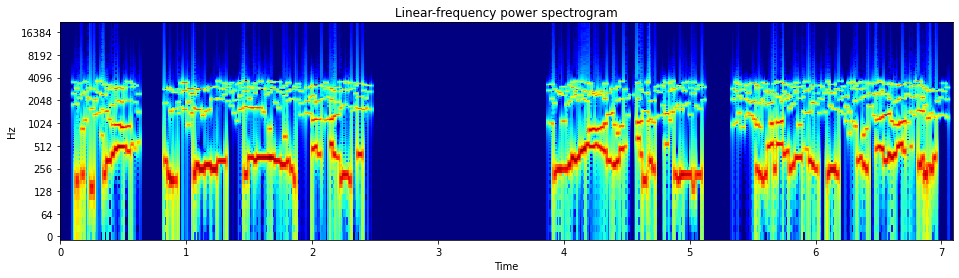

In [15]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

wavedata = output.astype(np.float) / 32767

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(111)
D = librosa.amplitude_to_db(np.abs(librosa.stft(wavedata)), ref=np.max)
img = librosa.display.specshow(D, y_axis='log', x_axis='time', sr=44100, ax=ax, cmap='jet')
ax.set(title='Linear-frequency power spectrogram')
ax.label_outer()

plt.show()


## Save sound file

In [8]:
base, _ = os.path.splitext(input_file)
fout = wave.open(base+'.wav', 'wb')
fout.setparams((1, 2, 44100, len(output), 'NONE', 'notcompressed'))
fout.writeframes(output)
fout.close()